# **Understanding urban forest traits and cooling impact using ECOSTRESS in Boulder, Colorado: an exploratory analysis**

**Introduction**

Urban forests are a critical civic asset that have immense aesthetic and cultural value (Barona 2015), improve human psychological well-being (Turner-Skoff and Cavender 2019), support urban biodiversity (Alvey 2006), regulate stormwater (Rahman et al. 2023), improve air quality (Barwise and Kumar 2020), and store carbon (Fargione et al. 2018). In addition to these benefits, trees and other vegetation in cities significantly reduce urban air and surface temperatures (Bowler et al. 2010; Ren et al. 2018; Yan et al. 2019; Yin et al. 2023) by providing shade and via transpiration (uptake and evaporation of water by plants). Due to the cooling benefits of urban vegetation, expanding a city’s urban tree canopy through tree planting has been proposed as a nature-based solution to provide “cool refugia” (Crum and Jenerette 2017) to mitigate the effects of climate change-induced increases the magnitude and frequency of urban heat waves (Russo et al. 2014).

However, we still do not have a detailed understanding of what properties of urban vegetation are associated with maximal cooling influence. One factor in particular that is understudied is the role of urban forest species composition and species traits, which are measurable properties of plants related to processes such as water, light, and nutrient use   (Farrell et al. 2022; Rahman et al. 2024). To address this gap, my research goal is to understand what tree species traits are associated with optimizing the cooling provided by urban vegetation. I hope to answer this question using a field-based approach, and a remote sensing approach which is described here. 

To understand how tree species composition and traits of the urban forest influence cooling, I plan to conduct a study of how species traits, tree density, and canopy cover are related to remotely-sensed estimates of evapotranspiration. In this notebook, I conducted a preliminary analysis of the effect of tree density on evapotranspiration derived from NASA’s ECOSTRESS instrument aboard the International Space Station. I focus this analysis on the city of Boulder, Colorado, who I am partnering with in this work.

Boulder is unique in having a well-established urban forestry program that uses state-of-the-art technology, data collection, and data sharing. Nestled in the foothills of the Front Range of the Rocky Mountains in the U.S. state of Colorado, Boulder has a semi-arid climate with warm summers that make the city vulnerable to extreme heat. The city has a fairly extensive urban tree canopy and is a leader in urban forestry, being named a Tree City USA by the National Arbor Day Foundation since 1984 (Wikipedia contributors 2023). In 2018, the City of Boulder released the Urban Forest Strategic Plan and in 2023, the City issued a State of the Urban Forest Report. The Strategic Plan outlines a goal to maintain the city's tree canopy at 16% (a no-net-loss goal) given ongoing declines in the tree canopy due to the emerald ash borer. Part of this strategy to maintain canopy cover is tree planting. However, we know little about what tree species provide the most cooling in Boulder. Fortunately, data from the city’s tree inventory and ECOSTRESS may provide some insights into how the structure and composition of Boulder’s urban forest influences transpiration, which is one of the mechanisms by which trees cool the urban environment.

In [30]:
# Standard library imports
import os

# Third-party imports
import cartopy.crs as ccrs
import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hvplot.pandas
import hvplot.xarray
import hvplot
import rasterio
import rioxarray as rxr
import requests
import xarray as xr
import warnings

# Library-specific imports
from geocube.vector import vectorize # Geocube package to the rescue!!!

# Notebook settings
warnings.filterwarnings('ignore')

In [6]:
# Set the project directory

project_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'urban-forest-traits')
data_dir = os.path.join(project_dir, 'data')

for a_dir in [project_dir, data_dir]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

In [7]:
# Check directory
!ls $project_dir
!ls $data_dir

data             species_list.csv
city_boundary.geojson        parks.geojson
ecostress-evapotranspiration public_trees.geojson
example.log


### **Data sources**

**Overview of Tree Inventory Data**

In 2015, the City of Boulder completed the most recent tree inventory with data that is publicly-available. The inventory included around 50,000 trees that are within the city’s responsibility area. In addition to tree species and diameter measurements, data about each tree’s planting area (e.g., curbside, metal grated pit, etc.) and disease metrics (City of Boulder Urban Forest Strategic Plan 2018). This dataset provides an estimate of the species composition of trees in the city.

However it is important to note that the inventory does not include all trees in the city. Notably, trees not in the public-right-of-way such as trees in backyards and natural areas within the city boundary (e.g., trees growing wild in creeks) are not included in the inventory.

>Data source:
> City of Boulder. n.d. “Tree Inventory Open Data.” City of Boulder Open Data. Accessed May 6, 2024. https://open-data.bouldercolorado.gov/datasets/dbbae8bdb0a44d17934243b88e85ef2b_0/about.

In [8]:
# Download public tree inventory data

print("Checking if data is downloaded...")
public_tree_path = os.path.join(project_dir, 
                                data_dir, 
                                'public_trees.geojson')

if os.path.exists(public_tree_path):
    
    trees_gdf = gpd.read_file(public_tree_path)
    print("Data is already downloaded.")
    
else:
    print("Data is not downloaded. Initiating download...")

    # Define URL
    public_trees_all_url = (
        'https://gis.bouldercolorado.gov/ags_svr2/rest/services/'
        'parks/TreesOpenData/MapServer/0/query?'
        'where=1%3D1&outFields=*&returnGeometry=false'
        '&returnIdsOnly=true&outSR=4326&f=json'
    )

    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=public_trees_all_url, 
                     headers={'User-Agent': user_agent})
    geojson_data = r.json()

    # Extract the objectIDs (the indexes of the rows in the dataset)
    objectid_list = geojson_data["objectIds"]

    # Define chunks from the row numbers
    chunks = [
        (objectid_list[i],
            objectid_list[min(i + 1000,
                                len(objectid_list)-1)])
        for i in range(0, len(objectid_list), 1000)
    ]
    print("Data chunks identified.")

    # # Due to the City of Boulder ArcGIS Hub limit of downloading
    # # a maximum of 2,000 items at a time,
    # # split the dataset into chunks and download the chunks individually.

    # # Download data for each chunk
    all_chunks_list = []
    for (min_objectid, max_objectid) in chunks:

        # Define url
        public_trees_object_ids_url = (
            'https://gis.bouldercolorado.gov/ags_svr2/rest/services/'
            'parks/TreesOpenData/MapServer/0/query?'
            "where=OBJECTID%20%3E%3D%20{min_objectid}"
            "%20AND%20OBJECTID%20%3C%3D%20{max_objectid}"
            "&outFields=*&outSR=4326&f=geojson"
        )

        # Download chunk of data
        r = requests.get(url=public_trees_object_ids_url.format(
            min_objectid=min_objectid,
            max_objectid=max_objectid),
            headers={'User-Agent': user_agent})

        # Read GeoJSON data into a GeoDataFrame
        geojson_data = r.json()
        chunk_gdf = (gpd.GeoDataFrame
                            .from_features(geojson_data['features'])
        )
        all_chunks_list.append(chunk_gdf)

    # Concatenate the chunk gdfs into one gdf
    public_trees_all_gdf = pd.concat(all_chunks_list)

    # Save downloaded data to CSV in directory
    public_trees_all_gdf.to_file(public_tree_path, driver='GeoJSON', 
                                 crs="EPSG:4326")

    trees_gdf = gpd.read_file(public_tree_path)
    print("Data download complete.")

Checking if data is downloaded...
Data is already downloaded.


In [11]:
trees_gdf.head()

OBJECTID FACILITYID SPECIESCD                FULLNAME  \
0         1  TREE79142      FRPE  Fraxinus pennsylvanica   
1         2  TREE79143      FRPE  Fraxinus pennsylvanica   
2         3  TREE79144      CASP        Catalpa speciosa   
3         4  TREE79145      CASP        Catalpa speciosa   
4         5  TREE79146      FRAM      Fraxinus americana   

                LATINNAME     GENUS CULTIVAR        COMMONNAME GENUSCOM  \
0  Fraxinus pennsylvanica  Fraxinus     None        Ash, Green      Ash   
1  Fraxinus pennsylvanica  Fraxinus     None        Ash, Green      Ash   
2        Catalpa speciosa   Catalpa     None  Catalpa, Western  Catalpa   
3        Catalpa speciosa   Catalpa     None  Catalpa, Western  Catalpa   
4      Fraxinus americana  Fraxinus     None        Ash, White      Ash   

   LEAFCYCLE  ... OWNEDBY           TREEDIST  \
0  Deciduous  ...    City  Northeast Boulder   
1  Deciduous  ...    City  Northeast Boulder   
2  Deciduous  ...    City  Northeast Boulder   
3  Deciduous  ...    City  Northeast Boulder   
4  Deciduous  ...    City  Northeast Boulder   

                                 GLOBALID PROPNAME CONFIDENCE DATACONF  \
0  {511B97EE-A1CF-49D3-8EE8-6897D4ABF868}     None       None     None   
1  {EB01B286-7B24-4A2D-ABD6-C3CAC41F34D1}     None       None     None   
2  {75239CC6-6A21-4FAF-93D0-FDB3680FBC15}     None       None     None   
3  {D7616678-C732-4EA5-8560-5B9B100FD520}     None       None     None   
4  {A21FA763-98E8-45C9-8BEE-7B7246EB70D1}     None       None     None   

  DIVERSITYINDEX SPECIESINDEX OTHERINDEX                     geometry  
0           None         None       None  POINT (-105.22100 40.02395)  
1           None         None       None  POINT (-105.22103 40.02378)  
2           None         None       None  POINT (-105.22109 40.02361)  
3           None         None       None  POINT (-105.22116 40.02349)  
4           None         None       None  POINT (-105.22174 40.02329)  

[5 rows x 30 columns]

In [18]:
# Clean up the tree database

# Are there trees with no geometry?
trees_gdf.geom_type[trees_gdf.geom_type != 'Point']

# display(trees_gdf.iloc[[44304, 44555]])
# trees_gdf.iloc[[44304, 44555]]['geometry']

44304    None
44555    None
dtype: object

In [22]:
# Drop trees with no geometry
# print(len(trees_gdf))

trees_cleaned_gdf = trees_gdf[trees_gdf['geometry'].notnull()]
# print(len(trees_cleaned_gdf))

trees_cleaned_gdf[trees_cleaned_gdf['geometry'].isna()]
trees_cleaned_gdf[trees_cleaned_gdf['geometry'].isnull()]

Empty GeoDataFrame
Columns: [OBJECTID, FACILITYID, SPECIESCD, FULLNAME, LATINNAME, GENUS, CULTIVAR, COMMONNAME, GENUSCOM, LEAFCYCLE, LEAFTYPE, DBHINT, NOTETREE, PROJECT, ADDRESS, ZIPCODE, ONSTREET, LOCTYPE, SITETYPE, MAINTBY, OWNEDBY, TREEDIST, GLOBALID, PROPNAME, CONFIDENCE, DATACONF, DIVERSITYINDEX, SPECIESINDEX, OTHERINDEX, geometry]
Index: []

[0 rows x 30 columns]

In [25]:
# Remove all tree genus names that are not strings

trees_names_gdf = trees_cleaned_gdf.copy()

# Remove non_strings
non_string_mask = trees_names_gdf['LATINNAME'].apply(lambda x: not isinstance(x, str))
trees_names_gdf = trees_names_gdf[~non_string_mask]
trees_names_gdf['LATINNAME_str'] = trees_names_gdf['LATINNAME'].astype(str)

names_that_are_not_strings = (trees_names_gdf[trees_names_gdf['LATINNAME']
                                 .apply(lambda x: not isinstance(x, str))])

names_that_are_not_strings

Empty GeoDataFrame
Columns: [OBJECTID, FACILITYID, SPECIESCD, FULLNAME, LATINNAME, GENUS, CULTIVAR, COMMONNAME, GENUSCOM, LEAFCYCLE, LEAFTYPE, DBHINT, NOTETREE, PROJECT, ADDRESS, ZIPCODE, ONSTREET, LOCTYPE, SITETYPE, MAINTBY, OWNEDBY, TREEDIST, GLOBALID, PROPNAME, CONFIDENCE, DATACONF, DIVERSITYINDEX, SPECIESINDEX, OTHERINDEX, geometry, LATINNAME_str]
Index: []

[0 rows x 31 columns]

In [123]:
# Plot trees
trees_plot = trees_names_gdf.hvplot(
    geo=True,
    tiles='EsriImagery',
    alpha =0.5,
    size=10,
    hover_cols='GENUS',
    c='GENUS',
    legend=False,
    title='Public trees in Boulder by genus'
)

trees_plot.opts(height=500, width=500)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (GENUS)

Boulder has a diversity of tree species of many different species–so many, in fact, that visualizing them all would be difficult! Instead we can visualize trees by genera. There do not seem to be any obvious patterns in genus diversity, with many genera in every part of the city. We can see that the western portion of the city seems to have a higher tree density than the northern as well as the center-eastern industrial part of the city. It appears that residential neighborhoods have more trees than commercial and industrial areas, and additionally older neighborhoods in the western part of the city have more trees.

Many of the trees in Boulder are in public parks, and a focus of my project will be understanding tree cooling effects in parks. The City of Boulder Open Data portal also has a dataset of public park which we can visualize.

>Data source:
>City of Boulder. n.d. “Properties Managed by Parks and Recreation Polygons.” City of Boulder Open Data. Accessed May 6, 2024. https://open-data.bouldercolorado.gov/.

In [27]:
# Download parks in Boulder polygons

parks_path = os.path.join(project_dir,
                          data_dir,
                          'parks.geojson')

if not os.path.exists(parks_path):
    print("Downloading park polygons.")

    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    parks_url = ('https://gis.bouldercolorado.gov/ags_svr2/rest/services/'
                 'parks/ParkSitesOpenData/MapServer/1/'
                 'query?outFields=*&where=1%3D1&f=geojson')

    response = requests.get(parks_url,
                            headers={'User-Agent': user_agent})
    parks_data = response.json()

    parks_gdf = gpd.GeoDataFrame.from_features(parks_data['features'])
    parks_gdf.crs = "EPSG:4326"

    parks_gdf.to_file(parks_path, driver='GeoJSON', 
                                 crs="EPSG:4326")
    print("Data downloaded and cached.")
    
else:
    parks_gdf = gpd.read_file(parks_path)
    print("Data already downloaded. Loaded data.")

parks_gdf.head()

Data already downloaded. Loaded data.


OBJECTID FACILITYID                                               NAME  \
0         1       PK26                          Hickory Community Gardens   
1         2       PK55                                  Maxwell Lake Park   
2         3       PK59  Boulder Reservoir Natural Area Little Dry Cree...   
3         4       PK52                                  Lover's Hill Park   
4         5      PK407              Boulder Creek Path Foothills to Pearl   

                   LABEL CITYPARK       PARKTYPE     PARKREACH  \
0        Hickory Gardens     Park         Garden   Pocket Park   
1      Maxwell Lake Park     Park  Natural Lands  Neighborhood   
2  Little Dry Creek West     Park  Natural Lands       Unknown   
3      Lover's Hill Park     Park           Park   Pocket Park   
4        Boulder Cr Path     Park           Path          City   

        SUBCOMMUNITY DESCRIP PROJECTS  ...     DEVELOPDT       RENOVDT  \
0  Southeast Boulder    None     None  ...           NaN           NaN   
1      North Boulder    None     None  ...  0.000000e+00           NaN   
2       Outside City    None     None  ...           NaN           NaN   
3    Central Boulder    None     None  ...  7.889184e+11  1.104538e+12   
4       East Boulder    None     None  ...           NaN           NaN   

          FORMERNAME LIFECYCLE  \
0                       Active   
1                       Active   
2  Natural Area-51st    Active   
3                       Active   
4                       Active   

                                            PHOTOURL LAST_EDITED_DATE  \
0  https://www.flickr.com/photos/bouldercolorado/...    1706720847000   
1  https://www.flickr.com/photos/bouldercolorado/...    1706720847000   
2                                               None    1706720847000   
3  https://www.flickr.com/photos/bouldercolorado/...    1706720847000   
4  https://www.flickr.com/photos/bouldercolorado/...    1706720847000   

                                 GLOBALID SHAPE.STArea() SHAPE.STLength()  \
0  {3BBB5BED-7374-4CC4-AC56-EA94A6AC9714}   3.578634e+04       741.986388   
1  {4925F079-7D0B-49E2-BCCB-16B1F9350CB8}   3.774509e+05      3849.313061   
2  {EE61EBEF-2EDE-49C4-AE71-21CF2D5AB3EA}   5.261514e+06     11340.013261   
3  {941D1A29-3BE6-44D0-AE8A-FF1FA77DA43D}   9.406584e+03       517.707739   
4  {68982AD1-1472-4291-83B7-EBF18B2CE756}   1.276924e+05      6640.298525   

                                            geometry  
0  POLYGON ((-105.23338 40.00175, -105.23338 40.0...  
1  POLYGON ((-105.28689 40.04266, -105.28711 40.0...  
2  POLYGON ((-105.24465 40.07290, -105.23953 40.0...  
3  POLYGON ((-105.26869 40.02506, -105.26866 40.0...  
4  POLYGON ((-105.23476 40.02190, -105.23482 40.0...  

[5 rows x 42 columns]

In [34]:
parks_plot = parks_gdf.hvplot(
    geo=True,
    line_color='black',
    tiles='EsriImagery',
    alpha=0.5,
    hover_cols='NAME',
    legend=False
)

parks_and_trees = (parks_plot * trees_plot).opts(
    height=500,
    width=800
)

# hvplot.save(parks_and_trees, 'parks_and_trees.html')
parks_and_trees

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (NAME)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (GENUS)

In [35]:
# Extract a species list (for use in other analyses)
unique_latin_names = trees_names_gdf['LATINNAME'].unique()

unique_df = pd.DataFrame({'LATINNAME': unique_latin_names})

unique_df

tree_species_list_path = os.path.join(project_dir, "species_list.csv")

unique_df.to_csv(tree_species_list_path, index=False)

In order to get the ECOSTRESS data we also need the City Boundary.

>Data source:
>City of Boulder. n.d. “City of Boulder City Limits.” City of Boulder Open Data. Accessed April 18, 2024. https://open-data.bouldercolorado.gov/.

In [37]:
# Download City of Boulder boundary

boundary_url = ("https://gis.bouldercolorado.gov/ags_svr1/rest/services/"
                "plan/CityLimits/MapServer/0/"
                "query?outFields=*&where=1%3D1&f=geojson")

boundary_path = os.path.join(data_dir, 'city_boundary.geojson')

if os.path.exists(boundary_path):
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data is already downloaded.")
else:
    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=boundary_url, headers={'User-Agent': user_agent})

    # Read GeoJSON data into a GeoDataFrame
    boundary_geojson_data = r.json()

    # Cache
    boundary_gdf = (gpd.GeoDataFrame
                    .from_features(boundary_geojson_data['features'])
                    .to_file(boundary_path, driver="GeoJSON")
                    )
    
    # Read
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data downloaded and loaded.")

# boundary_gdf.plot()

Data is already downloaded.


**ECOSTRESS data**

The ECOSTRESS instrument aboard the International Space Station provides multiple high resolution (70m by 70m) data products related to ECOSTRESS water and energy flows. Here I used the Canopy Transpiration product which uses input data from ECOSTRESS, MODIS, and other sources to estimate the proportion of evapotranspiration (ET) that is via vegetation canopy transpiration (Fisher 2018; Halverson et al. 2019). This is a Level 3 product and quality control (e.g., removing pixels with clouds) is already applied using data from a quality assurance layer (Halverson et al. 2019). It is important to note that the JPL evapotranspiration algorithm includes as input data the leaf area index derived from MODIS (itself derived from NDVI) (Fisher 2018) and therefore there is an inherent correlation between tree canopy and the ECOSTRESS canopy transpiration. In the future, where I plan to analyze tree traits, I will address this fact by controlling for leaf area index.

Overall, this canopy transpiration data describes how much of the water leaving the ecosystem is leaving via uptake and transpiration from vegetation (as opposed to directly evaporating from the ground). Because transpiration is related to heat loss from the Earth surface, it provides an estimate of the cooling impact of vegetation. A more rigorous analysis however should consider both the fraction of ET that is due to the vegetation canopy and the total ET to assess the magnitude of vegetation cooling impact (but is not considered in this preliminary analysis).

>Data source:
>Hook, Simon, and Fisher, Joshua. 2019. “ECOSTRESS Evapotranspiration PT-JPL Daily L3 Global 70 m V001 [Data Set].” NASA EOSDIS Land Processes Distributed Active Archive Center. https://doi.org/10.5067/ECOSTRESS/ECO3ETPTJPL.001.

In [116]:
# Initialize AppeearsDownloader for MODIS NDVI data
evapot_downloader = etapp.AppeearsDownloader(
    download_key="ecostress-evapotranspiration", # optional
    ea_dir=data_dir,
    product="ECO3ETPTJPL.001",  # from list of APPEEARS datasts
    layer="EVAPOTRANSPIRATION_PT_JPL_ETcanopy",
    start_date="04-01",
    end_date="10-31",
    recurring=True,
    year_range=[2021, 2022],
    polygon=boundary_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(evapot_downloader.data_dir):
    evapot_downloader.download_files()

ecostress_data_path = os.path.join(data_dir, 'ecostress-evapotranspiration', 'ECO3ETPTJPL.001_2021091_to_2022304')
# print(ecostress_data_path)

In [131]:
def compile_info(path):
    """
    Given a path to ECOSTRESS data downloaded from APPEEARS, compiles a 
    pandas.DataFrame of the file paths on the local machine 
    with the date for each image.

    Parameters:
    ----------
    path : path
        Path to the folder with the ECOSTRESS data.

    Returns:
    -------
    pandas.DataFrame
        DataFrame containing paths on local machine and date for each
        image file.
    """

    # Generate list of data files
    path_list = glob.glob(
        os.path.join(path, "*.tif")
    )

    path_df = pd.DataFrame({"file_path": path_list})

    # Merge images into a single data array

    doy_start = -25  # the character number of the start of doy in file name
    doy_end = -18  # the character number of the end of doy in file name
    # the other characters after are time in UTC
    scale_factor = 1  # from documentation?

    # For every file (.tif image), add it to the list
    for index, image, in path_df.iterrows():

        # Get date from file name
        doy = image['file_path'][doy_start:doy_end]

        # Define the date variable as the doy in file name
        date = pd.to_datetime(doy, format='%Y%j')

        # Add the dates to the DF
        path_df.loc[index, 'doy'] = doy
        path_df.loc[index, 'date'] = date

    return path_df

image_paths = compile_info(ecostress_data_path)

In [43]:
# Test with a subset of the data
# image_paths_subset = image_paths.iloc[0:5]
# display(image_paths_subset)

In [133]:
def open_data(path_df, cached_data_path, diagnostics=False):

    """
    Given a DataFrame with file paths and a path to cache data, 
    opens each image, matches grids, concatenates by date, 
    and caches the result.

    Parameters:
    ----------
    path_df : pandas.DataFrame
        Must contain file paths in a column 'file_path' 
        and dates in a column 'date'.

    cached_data_path : str
        Location on local machine to save resultant DataArray.

    diagnostics: bool, optional
        If True, only processes the first image and prints 
        diagnostic plots. Can be helpful to assess if the function is
        behaving as expected and if the data was downloaded correctly.

    Returns:
    -------
    xarray.DataArray
        A DataArray with a coordinate date for each image, 
        and x, y coordinates.
    """

    images_list = [] 

    for index, image in path_df.iterrows():
        
        path = image['file_path']

        da = rxr.open_rasterio(path, masked=True)

        # Add date as a coordinate
        date = image['date']
        da = da.assign_coords(date=date)

        # display(da)

        images_list.append(da)

        # Add date as a coordinate

        # Show diagnostic plots for the first image
        if diagnostics==True:

            print(f'Diagnostics for date: {date}')

            display(da)

            crs = da.rio.crs
            print(crs)

            bounds = da.rio.bounds()
            print(bounds)

            # Plots
            da.plot()
            plt.title(date)

            boundary_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')
            plt.show()

            break

        else:

            # print("Loaded")

            continue

    # Reproject match
    target_grid = images_list[0]
    images_reprojected_list = []

    for image in images_list:
        image_reprojected = image.rio.reproject_match(target_grid)

        images_reprojected_list.append(image_reprojected)
    

    num_images = len(images_reprojected_list)
    print(f'Number of ECOSTRESS images is {num_images}.')
        
    # Concatenate into a data array
    dates_da = xr.concat(images_reprojected_list, dim='date')

    if diagnostics==True:
        dates_da[0].plot()
        plt.show()
    
    # Cache as a netCDF
    dates_da.to_netcdf(path=cached_data_path)
    print("Data loaded and cached.")

    # Calculate bounds
    bounds = dates_da.rio.bounds()
    print("Total bounds of ECOSTRESS imagery:", bounds)
    
    return dates_da

In [134]:
ecostress_combined_path = os.path.join(data_dir, 'ecostress_combined.nc')

if os.path.exists:
    all_dates_da = open_data(path_df=image_paths,
                             cached_data_path=ecostress_combined_path, 
                             diagnostics=False)
else:
    all_dates_da = xr.open_dataset(ecostress_combined_path)

# Compare with bounds of the city
city_bbox = boundary_gdf.total_bounds
print(f'City bounds: {city_bbox}')

Number of ECOSTRESS images is 85.
Data loaded and cached.
Total bounds of ECOSTRESS imagery: (-105.30188636429178, 39.956324033926975, -105.17766195880746, 40.09505179639679)
City bounds: [-105.30145091   39.95691668 -105.17809882   40.09448471]


ET varies across space, but it also varies across time. Because I am primarily interested in variation across space, I averaged ET across all the dates of data for this analysis.

<xarray.DataArray (band: 1, y: 220, x: 197)>
array([[[62.247826, 63.493183, 63.448845, ..., 51.436577, 57.916897,
         61.670506],
        [64.71858 , 65.16196 , 64.8582  , ..., 54.216713, 58.55236 ,
         62.4789  ],
        [65.99713 , 66.23787 , 64.08386 , ..., 55.194862, 59.055786,
         62.616497],
        ...,
        [47.250168, 52.30344 , 52.935104, ..., 62.12771 , 63.159237,
         63.377098],
        [46.428974, 49.705494, 49.279408, ..., 65.03614 , 62.176846,
         59.600056],
        [46.832283, 45.816303, 48.20122 , ..., 67.945465, 65.87038 ,
         65.773506]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.2 -105.2 -105.2
  * y            (y) float64 40.09 40.09 40.09 40.09 ... 39.96 39.96 39.96 39.96

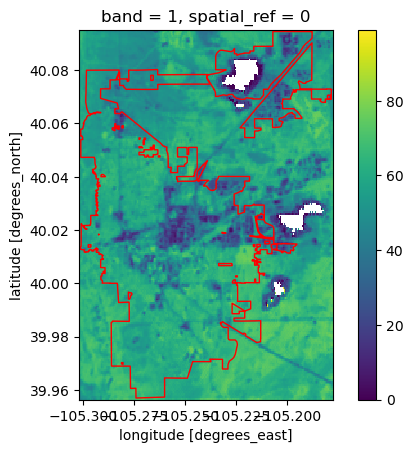

In [136]:
# Take the mean at each pixel
mean_da = all_dates_da.mean(dim='date', skipna=True)

display(mean_da)

# View
mean_da.plot()
boundary_gdf.plot(ax=plt.gca(), color='none', edgecolor='red')

plt.show()

### **Interactive ECOSTRESS Evapotranspiration map**

In [137]:
ET_plot = (mean_da.sel(band=1).hvplot(cmap='viridis', geo=True, tiles='EsriImagery', alpha=0.7) * boundary_gdf.hvplot(geo=True, fill_alpha=0))

ET_plot_big = ET_plot.opts(width=600, height=600, title='Canopy transpiration across the study area')

# hvplot.save(ET_plot_big, 'ET_plot_big.html')

ET_plot_big

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Image.I    :Image   [x,y]   (value)
   .Polygons.I :Polygons   [Longitude,Latitude]

### **Compare urban forest structure to ET**

In [138]:
%%bash
# If you don't already have geocube installed, it is needed here
# pip install geocube

In [139]:
# Vectorize the raster

# Check if crs's match
# print(trees_gdf.crs)
# print(mean_da.rio.crs)

ET_vectorized = vectorize(mean_da)
ET_vectorized = ET_vectorized.rename(columns={'_data': 'ET'})
ET_vectorized.head()

ET                                           geometry
0  62.247826  POLYGON ((-105.30189 40.09505, -105.30189 40.0...
1  63.493183  POLYGON ((-105.30126 40.09505, -105.30126 40.0...
2  63.448845  POLYGON ((-105.30063 40.09505, -105.30063 40.0...
3  62.053909  POLYGON ((-105.29999 40.09505, -105.29999 40.0...
4  59.768463  POLYGON ((-105.29936 40.09505, -105.29936 40.0...

In [143]:
ET_gdf = ET_vectorized.reset_index()
ET_gdf = ET_gdf.rename(columns={'index': 'pixel_index'})

# ET_gdf.head()

In [144]:
# Test to see if the vectorization worked
# ax = ET_gdf.plot(column='ET', cmap='viridis', alpha=0.4)
# trees_gdf.plot(ax=ax, column='GENUS')

# plt.show()

In [145]:
# Join the trees to the raster vectors
trees_et_gdf = gpd.sjoin(ET_gdf, trees_gdf, how='left', op='intersects')
# trees_et_gdf.head()

In [146]:
# Check if the spatial join worked
# trees_et_gdf.dropna(subset=['index_right']).plot(column='ET', cmap='viridis', alpha=0.4)

In [147]:
# Calculate density of trees for each ECOSTRESS pixel
# Eventually this code can be expanded to calculate other patch-level
# characteristics such as average trait values, species diversity, etc.

unique_trees = (trees_et_gdf
                .dropna(subset=['index_right'])
                .groupby('pixel_index')
                .size()  # Count the number of unique occurrences for each group
                .reset_index()  # Reset the index to convert the result to a DataFrame
)

trees_summary = (pd.merge(ET_gdf, unique_trees, how='left', on='pixel_index')
                 .rename(columns={0: 'num_trees'})
)

trees_summary.head()

# trees_summary['num_trees'].plot.hist()

pixel_index         ET                                           geometry  \
0            0  62.247826  POLYGON ((-105.30189 40.09505, -105.30189 40.0...   
1            1  63.493183  POLYGON ((-105.30126 40.09505, -105.30126 40.0...   
2            2  63.448845  POLYGON ((-105.30063 40.09505, -105.30063 40.0...   
3            3  62.053909  POLYGON ((-105.29999 40.09505, -105.29999 40.0...   
4            4  59.768463  POLYGON ((-105.29936 40.09505, -105.29936 40.0...   

   num_trees  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [127]:
trees_ET_adj = trees_summary[trees_summary['num_trees'] > 10]

# See distribution of tree numbers per pixels
# trees_ET_adj['num_trees'].plot.hist()

### Figure 1

In [148]:
scatter_plot = trees_ET_adj.hvplot.scatter(x='num_trees', y='ET')
scatter_plot.opts(title = "Number of public trees versus canopy transpiration", xlabel='number of trees in ECOSTRESS pixel', ylabel='canopy transpiration')

:Scatter   [num_trees]   (ET)

Finally, what patterns do we see with tree density and canopy transpiration fraction of ET (a proxy for vegetation cooling effects)? Even if we only look at ECOSTRESS pixels with more than 10 trees (i.e., remove pixels in areas with poor inventory coverage), Figure 1 shows that tree density, the number of trees is not a good predictor of canopy ET. In fact, there are many pixels with very few inventoried trees but high canopy ET. This result is likely due to the fact that the public tree inventory does not include all trees in Boulder. Therefore, some ECOSTRESS pixels may have high canopy ET due to having high canopy cover, but because the trees providing this canopy cover are not inventoried, this analysis shows no relationship.

To address this issue, I hope to use a more updated public tree inventory (yet to be released) to calculate species composition metrics and incorporate NAIP data to identify clusters of trees, and then use these data products in my analysis. This approach will treat inventoried trees as representative samples of  "clusters" of trees which can then be analyzed.

### Figure 2

In [149]:
num_trees_plot = (trees_summary.dropna().hvplot(geo=True, color='num_trees',
                                                cmap='viridis',
                                                line_color='clear')
                  * boundary_gdf.hvplot(geo=True,
                                        fill_alpha=0,
                                        tiles='EsriImagery'))
num_trees_plot.opts(height=600, width=600,
                    title=("Number of trees per ECOSTRESS pixel"
                           "\nis low across Boulder")
                    )

hvplot.save(num_trees_plot, 'tree_density_plot.html')

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : line_color='clear' [closest match: 'color'] {renderer: GlyphRenderer(id='p118095', ...)}


Finally, what spatial patterns do we see with tree density and canopy transpiration fraction of ET (a proxy for vegetation cooling effects)? From the map, it is clear that most ECOSTRESS pixels have very few trees. Therefore to test whether urban forest characteristics are associated with canopy transpiration using this public tree inventory dataset, it is necessary to aggregrate ECOSTRESS pixels (bin the data) to capture more trees in each spatial replicate. There are likely multiple different approaches to aggregating the ECOSTRESS pixels. For example, we can combine some number of adjacent pixels into pixel clusters and analyze the clusters in relation to the respective ECOSTRESS data.